#### Importing libraries and installing dependencies

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt
%matplotlib inline

#avoid all warnings
import warnings
warnings.filterwarnings("ignore")

D:\anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
#Import the NLP library and dowmload the stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Dataset

In [13]:
#Reading csv file of XML parsed ~6000 DOIs. <path> contains the file
df = pd.read_csv(r'C:\Users\Admin\OneDrive - IIT Delhi\CPCB\PROF. HARI\Jupyter_file\Ex_scibert\Abstract\final_abstract_6000_final.csv')
df.head()

,Unnamed: 0,DOI,Title,Abstract
0,0,10.1016/j.tet.2021.132473,Homogeneous first-row transition metal catalys...,The recent advances in homogeneous first-row t...
1,1,10.1016/j.apcatb.2020.119868,Selective photoelectrocatalytic tuning of benz...,Hydrogen production can be promoted by replaci...
2,2,10.1016/j.rser.2020.110523,Light alcohols reforming towards renewable hyd...,Fuel cells (FC) produce electricity in a conti...
3,3,10.1016/j.apsusc.2021.150446,Minimized Pt deposition on CdS simultaneously ...,Constructing coupling reaction system is an ef...
4,4,10.1016/j.cej.2021.129870,Boosting photocatalytic hydrogen production co...,Photocatalytic H2 production or photocatalytic...


In [14]:
#44 missing values are dropped. Total of 5901 abstracts are processed
df.isnull().sum() #44 missing null values

Unnamed: 0     0
DOI            0
Title          0
Abstract      44
dtype: int64

In [15]:
df = df.dropna(axis=0)
df.head()

,Unnamed: 0,DOI,Title,Abstract
0,0,10.1016/j.tet.2021.132473,Homogeneous first-row transition metal catalys...,The recent advances in homogeneous first-row t...
1,1,10.1016/j.apcatb.2020.119868,Selective photoelectrocatalytic tuning of benz...,Hydrogen production can be promoted by replaci...
2,2,10.1016/j.rser.2020.110523,Light alcohols reforming towards renewable hyd...,Fuel cells (FC) produce electricity in a conti...
3,3,10.1016/j.apsusc.2021.150446,Minimized Pt deposition on CdS simultaneously ...,Constructing coupling reaction system is an ef...
4,4,10.1016/j.cej.2021.129870,Boosting photocatalytic hydrogen production co...,Photocatalytic H2 production or photocatalytic...


**ChemDataExtractor doesn't detect lowered text for catalysts/ molecular compounds. 
But lemmatization, stopword removal and punctuation removal are done prior to catalyst detection** 

#### Text Cleaning

In [16]:
#Cleaning
def clean(df, column):
    df[column] = df[column].str.replace('[^\w\s]',' ') #Removes any kind of punctuation
    df[column] = df[column].str.lstrip() #Strips of spaces from left and right ends of the abstract
    df[column] = df[column].str.rstrip()
    
#Stopword Removal
stop = stopwords.words('english')
def stop_remover(dfc, column):
    dfc[column] = dfc[column].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

#Lemmatization
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w,'v') for w in w_tokenizer.tokenize(text)]
    
clean(df, 'Abstract') #Text is cleaned for punctuation and spaces
clean(df, 'Title')

stop_remover(df, 'Abstract') #Stopwords are removed
stop_remover(df, 'Title')

df['Abstract_lemm'] = df['Abstract'].apply(lemmatize_text).apply(lambda x: " ".join(x)) #All the words are lemmatized to avaoing confusion 'alcohol' & 'alcohols'
df['Title_lemm'] = df['Title'].apply(lemmatize_text).apply(lambda x: " ".join(x))

df.head()

,Unnamed: 0,DOI,Title,Abstract,Abstract_lemm,Title_lemm
0,0,10.1016/j.tet.2021.132473,Homogeneous first row transition metal catalys...,The recent advances homogeneous first row tran...,The recent advance homogeneous first row trans...,Homogeneous first row transition metal catalys...
1,1,10.1016/j.apcatb.2020.119868,Selective photoelectrocatalytic tuning benzyl ...,Hydrogen production promoted replacing sluggis...,Hydrogen production promote replace sluggish o...,Selective photoelectrocatalytic tune benzyl al...
2,2,10.1016/j.rser.2020.110523,Light alcohols reforming towards renewable hyd...,Fuel cells FC produce electricity continuous m...,Fuel cells FC produce electricity continuous m...,Light alcohols reform towards renewable hydrog...
3,3,10.1016/j.apsusc.2021.150446,Minimized Pt deposition CdS simultaneously max...,Constructing coupling reaction system effectiv...,Constructing couple reaction system effective ...,Minimized Pt deposition CdS simultaneously max...
4,4,10.1016/j.cej.2021.129870,Boosting photocatalytic hydrogen production co...,Photocatalytic H2 production photocatalytic or...,Photocatalytic H2 production photocatalytic or...,Boosting photocatalytic hydrogen production co...


#### ChemDataExtractor

In [18]:
#library imported
from chemdataextractor import Document
import chemdataextractor

In [19]:
df['Compounds'] = 0

In [20]:
df = df.reset_index(drop=True)
df.head()

,Unnamed: 0,DOI,Title,Abstract,Abstract_lemm,Title_lemm,Compounds
0,0,10.1016/j.tet.2021.132473,Homogeneous first row transition metal catalys...,The recent advances homogeneous first row tran...,The recent advance homogeneous first row trans...,Homogeneous first row transition metal catalys...,0
1,1,10.1016/j.apcatb.2020.119868,Selective photoelectrocatalytic tuning benzyl ...,Hydrogen production promoted replacing sluggis...,Hydrogen production promote replace sluggish o...,Selective photoelectrocatalytic tune benzyl al...,0
2,2,10.1016/j.rser.2020.110523,Light alcohols reforming towards renewable hyd...,Fuel cells FC produce electricity continuous m...,Fuel cells FC produce electricity continuous m...,Light alcohols reform towards renewable hydrog...,0
3,3,10.1016/j.apsusc.2021.150446,Minimized Pt deposition CdS simultaneously max...,Constructing coupling reaction system effectiv...,Constructing couple reaction system effective ...,Minimized Pt deposition CdS simultaneously max...,0
4,4,10.1016/j.cej.2021.129870,Boosting photocatalytic hydrogen production co...,Photocatalytic H2 production photocatalytic or...,Photocatalytic H2 production photocatalytic or...,Boosting photocatalytic hydrogen production co...,0


In [21]:
#Passing a text
for i in range(5901):
        doc = Document(df['Abstract'][i])
        array = np.array(doc.cems)
        listToStr = ' '.join([str(elem) for elem in array])
        comp_array = np.array(listToStr)
        s = comp_array.tolist().split()        
        s = list(set(s))
        listToStr2 = ' '.join([str(elem) for elem in s])
        df['Compounds'][i] = listToStr2

#Chemical entity mention
df['Compounds']

0       Pt Mn acid heterocycle formamide Co methanol h...
1       benzyl alcohol oxygen Hydrogen Bi2MoO6 hydroge...
2       CO alcohols monoxide CH4 hydrogen platinum car...
3       Pt CdS aromatic H 2 alcohols hydrogen H2 aldeh...
4       CdS benzyl alcohol 2334 Fe 1h g μmol H2 1 MIL ...
                              ...                        
5896                       CO monoxide hydrogen H2 carbon
5897    alcohol 5 sugar alcohols CaCO3 phenols 39 anhy...
5898             metal silica alcohols nerol oxide citral
5899    acid tetrachloride hydrogen ferriferrous methy...
5900    propane Ni γ propene Al2O3 palladium NiAl2O4 o...
Name: Compounds, Length: 5901, dtype: object

#### Word cloud

In [25]:
!pip install wordcloud

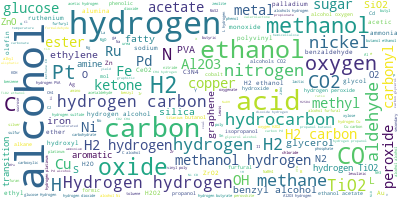

In [26]:
from wordcloud import WordCloud

# Joining all the processed lines together. Whole PDF
long_string = ','.join([str(i) for i in list(df['Compounds'].values)])

# WordCloud object
wordcloud = WordCloud(background_color="white", 
                      max_words=100000, 
                      contour_width=5, 
                      contour_color='steelblue',
                      repeat = False,
                      relative_scaling = 0.5,
                      min_font_size=3,
                      max_font_size = 40)
wordcloud.generate(long_string)

# Visualizing
wordcloud.to_image()

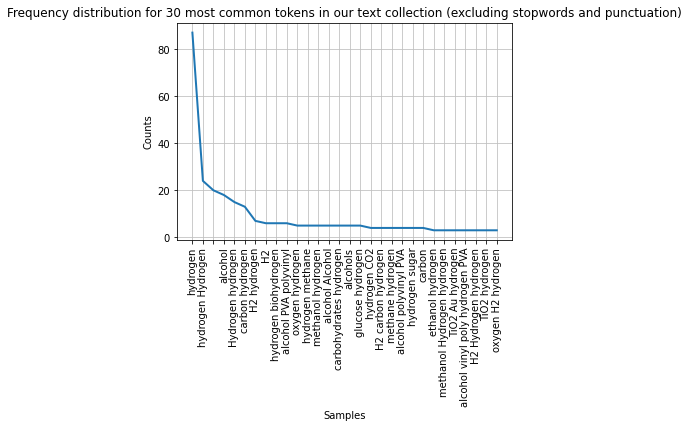

<AxesSubplot:title={'center':'Frequency distribution for 30 most common tokens in our text collection (excluding stopwords and punctuation)'}, xlabel='Samples', ylabel='Counts'>

In [27]:
from nltk import FreqDist
fdist_filtered = FreqDist(df['Compounds'])
fdist_filtered.plot(30,title='Frequency distribution for 30 most common tokens in our text collection (excluding stopwords and punctuation)')

In [28]:
#Lemmatized abstract is converted to lower case
df['Abstract_lemm'] = df['Abstract_lemm'].str.lower()
df.head()

,Unnamed: 0,DOI,Title,Abstract,Abstract_lemm,Title_lemm,Compounds
0,0,10.1016/j.tet.2021.132473,Homogeneous first row transition metal catalys...,The recent advances homogeneous first row tran...,the recent advance homogeneous first row trans...,Homogeneous first row transition metal catalys...,Pt Mn acid heterocycle formamide Co methanol h...
1,1,10.1016/j.apcatb.2020.119868,Selective photoelectrocatalytic tuning benzyl ...,Hydrogen production promoted replacing sluggis...,hydrogen production promote replace sluggish o...,Selective photoelectrocatalytic tune benzyl al...,benzyl alcohol oxygen Hydrogen Bi2MoO6 hydroge...
2,2,10.1016/j.rser.2020.110523,Light alcohols reforming towards renewable hyd...,Fuel cells FC produce electricity continuous m...,fuel cells fc produce electricity continuous m...,Light alcohols reform towards renewable hydrog...,CO alcohols monoxide CH4 hydrogen platinum car...
3,3,10.1016/j.apsusc.2021.150446,Minimized Pt deposition CdS simultaneously max...,Constructing coupling reaction system effectiv...,constructing couple reaction system effective ...,Minimized Pt deposition CdS simultaneously max...,Pt CdS aromatic H 2 alcohols hydrogen H2 aldeh...
4,4,10.1016/j.cej.2021.129870,Boosting photocatalytic hydrogen production co...,Photocatalytic H2 production photocatalytic or...,photocatalytic h2 production photocatalytic or...,Boosting photocatalytic hydrogen production co...,CdS benzyl alcohol 2334 Fe 1h g μmol H2 1 MIL ...


## LDA

* [Reference 1](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)
* [Reference 2](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)
* [Reference 3](https://towardsdatascience.com/topic-modeling-with-latent-dirichlet-allocation-e7ff75290f8)
* [Reference 4](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf)

In [29]:
#Tokenize words and further clean-up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  
        
data = df['Abstract_lemm'].tolist()
data_words = list(sent_to_words(data))

In [30]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [31]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [33]:
import spacy


# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

SyntaxError: invalid syntax (<ipython-input-33-8b75ff34b5c2>, line 2)

In [9]:
print(data_lemmatized[1:2])

[['hydrogen', 'production', 'promote', 'replace', 'sluggish', 'oxygen', 'evolution', 'reaction', 'oer', 'favorable', 'reaction', 'primary', 'oxidation', 'reaction', 'benzyl', 'alcohol', 'benzaldehyde', 'benzyl', 'alcohol', 'benzaldehyde', 'realize', 'selectivity', 'originate', 'enhance', 'adsorption', 'activation', 'benzyl', 'alcohol', 'photoanode', 'confirm', 'test', 'situ', 'ftir', 'technique', 'electron', 'generate', 'controllable', 'selective', 'primary', 'oxidation', 'reaction', 'utilize', 'source', 'synergistical', 'hydrogen', 'production', 'amount', 'generate', 'hydrogen', 'time', 'high', 'oer', 'efficiency', 'hydrogen', 'production', 'high', 'propose', 'strategy', 'combine', 'solar', 'energy', 'biomass', 'efficient', 'production', 'valuable', 'raw_material', 'benzaldehyde', 'well', 'green', 'energy', 'source', 'hydrogen']]


In [10]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 2), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 3), (27, 1), (28, 1), (29, 1), (30, 1), (31, 5), (32, 2), (33, 1), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 3), (41, 1), (42, 1), (43, 3), (44, 2), (45, 1), (46, 3), (47, 1), (48, 1), (49, 1), (50, 1), (51, 3), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 2), (64, 1), (65, 1), (66, 1)]]


## Base Model

Code for Base model LDA with default alpha and beta values

In [ ]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [ ]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Coherence Score is a measure for performance of LDA. LDA model is run mutliple times in a loop to maximize the coherence score for hyperparameters number of topics, alpha and beta.

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

## Analysis

In [52]:
a1 = pd.read_csv(r'C:\Users\swath\lda_tuning_results.csv')
a1

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.392252
1,75% Corpus,2,0.01,0.31,0.387186
2,75% Corpus,2,0.01,0.61,0.396402
3,75% Corpus,2,0.01,0.9099999999999999,0.396402
4,75% Corpus,2,0.01,symmetric,0.377741
...,...,...,...,...,...
535,100% Corpus,10,asymmetric,0.01,0.453058
536,100% Corpus,10,asymmetric,0.31,0.485945
537,100% Corpus,10,asymmetric,0.61,0.481152
538,100% Corpus,10,asymmetric,0.9099999999999999,0.457298


In [63]:
dd = pd.DataFrame()
dd  = a1.loc[(a1.Alpha == '0.61') & (a1.Beta == '0.61') & (a1.Validation_Set == '75% Corpus')]
#dd = a1.loc[a1.Topics == 9]
dd.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
12,75% Corpus,2,0.61,0.61,0.412808
42,75% Corpus,3,0.61,0.61,0.382847
72,75% Corpus,4,0.61,0.61,0.392846
102,75% Corpus,5,0.61,0.61,0.424427
132,75% Corpus,6,0.61,0.61,0.411924


In [64]:
dd.Coherence.nlargest(2)

222    0.502366
192    0.469980
Name: Coherence, dtype: float64

In [65]:
a1.loc[221]

Validation_Set    75% Corpus
Topics                     9
Alpha                   0.61
Beta                    0.31
Coherence           0.489087
Name: 221, dtype: object

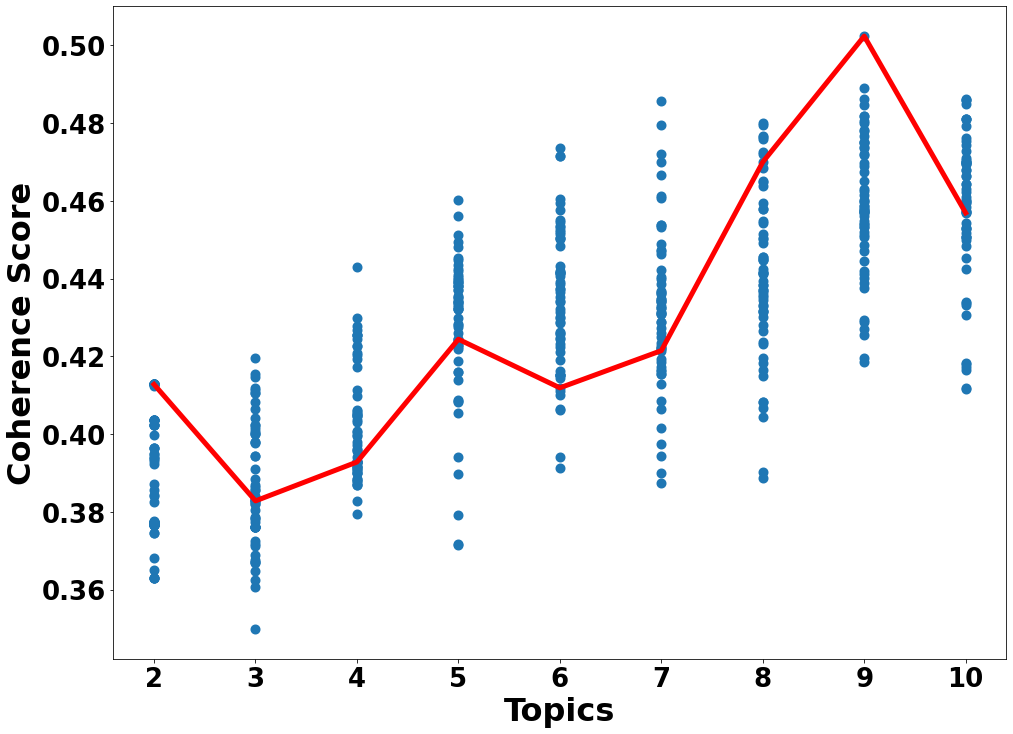

In [70]:
import matplotlib.pyplot as plt

x = dd['Topics']
y = dd['Coherence']

plt.figure(figsize = (16, 12), linewidth = 20)
plt.plot(x, y, c='r', linewidth=5)
plt.scatter(a1['Topics'], a1['Coherence'], linewidths=4)
plt.xlabel('Topics', fontweight='bold', fontsize=32)
plt.ylabel('Coherence Score', fontweight='bold', fontsize=32)
plt.xticks(fontweight='bold', fontsize=26)
plt.yticks(fontweight='bold', fontsize=26)
#plt.title('LDA: Topics vs Coherence Score (alpha=0.61, beta=0.61)', fontweight='bold', fontsize=28)
plt.show()


In [ ]:
maximum_Coherence = a1.Coherence.max()
maxValueIndex = a1.Coherence.idxmax()
print(maximum_Coherence, maxValueIndex)

In [27]:
a1.loc[222]

Validation_Set    75% Corpus
Topics                     9
Alpha                   0.61
Beta                    0.61
Coherence           0.502366
Name: 222, dtype: object

## Final Model

In [16]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=9, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.61,
                                           eta=0.61)

In [17]:
#import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.087224 -0.134821  1       1        20.209999
1      0.128973  0.079043  2       1        17.481789
8      0.131562  0.045214  3       1        17.259272
0      0.100331  0.080075  4       1        14.021421
2      0.034909 -0.161134  5       1        13.553413
6     -0.021161  0.084720  6       1        7.468591 
3     -0.116677 -0.019855  7       1        5.990798 
7     -0.123026 -0.013841  8       1        3.270627 
4     -0.222137  0.040600  9       1        0.744089 , topic_info=            Term         Freq        Total Category  logprob  loglift
11    catalyst    6619.000000  6619.000000  Default  30.0000  30.0000
134   fuel        1780.000000  1780.000000  Default  29.0000  29.0000
50    production  6054.000000  6054.000000  Default  28.0000  28.0000
3     alcohol     4189.000000  4189.000000  Default  27.0000  27.0000
31    hydrogen    8492.000000  8492.000000  Default  26.0000  26.0000
...        ...            ...          ...      ...      ...      ...
6408  aop         1.069077     8.332934     Topic9  -8.2231   2.8473 
4734  alkalinity  1.273739     18.477141    Topic9  -8.0480   2.2262 
4343  aq          1.033032     8.458691     Topic9  -8.2574   2.7981 
5254  ccd         1.111522     15.909521    Topic9  -8.1842   2.2396 
3383  lipase      1.093265     54.984355    Topic9  -8.2007   0.9829 

[623 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1422  1      0.009901  absorption
1422  2      0.108916  absorption
1422  3      0.034655  absorption
1422  4      0.757463  absorption
1422  5      0.004951  absorption
...  ..           ...         ...
268   1      0.007386  μmol      
268   2      0.007386  μmol      
268   3      0.007386  μmol      
268   4      0.967595  μmol      
268   5      0.007386  μmol      

[3248 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 9, 1, 3, 7, 4, 8, 5])

In [18]:
#most dominant topic for each document
doc_lda = lda_model[corpus]

corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in doc_lda]
topics = [[(term, round(wt, 3)) for term, wt in lda_model.show_topic(n, topn=10)] for n in range(0, lda_model.num_topics)]

topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 11)], index=['Topic '+str(t) for t in range(1, lda_model.num_topics+1)]).T
topics_df.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
Term1,hydrogen,catalyst,production,alcohol,chelator,hydrogen,pva,fuel,catalyst
Term2,photocatalytic,co,hydrogen,induce,bionic,production,membrane,engine,reaction
Term3,tio,alcohol,yield,level,ppta,process,film,oil,temperature
Term4,production,hydrogenation,concentration,activity,azobenzene,energy,alcohol,diesel,hydrogen
Term5,high,reaction,high,cell,bme,fuel,polymer,blend,support


In [73]:
topics_df.to_csv('topics.csv')

In [19]:
# column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, lda_model.num_topics+1)] )
topics_df

,Terms per Topic
Topic1,"hydrogen, photocatalytic, tio, production, high, activity, evolution, photocatalyst, performance, efficient"
Topic2,"catalyst, co, alcohol, hydrogenation, reaction, high, catalytic, selectivity, conversion, product"
Topic3,"production, hydrogen, yield, concentration, high, produce, rate, fermentation, substrate, study"
Topic4,"alcohol, induce, level, activity, cell, enzyme, ethanol, increase, effect, study"
Topic5,"chelator, bionic, ppta, azobenzene, bme, tfhfese, azo, emim, pmso, sce"
Topic6,"hydrogen, production, process, energy, fuel, produce, high, gas, biomass, system"
Topic7,"pva, membrane, film, alcohol, polymer, water, composite, increase, property, show"
Topic8,"fuel, engine, oil, diesel, blend, biodiesel, combustion, emission, alcohol, increase"
Topic9,"catalyst, reaction, temperature, hydrogen, support, high, study, result, carbon, show"


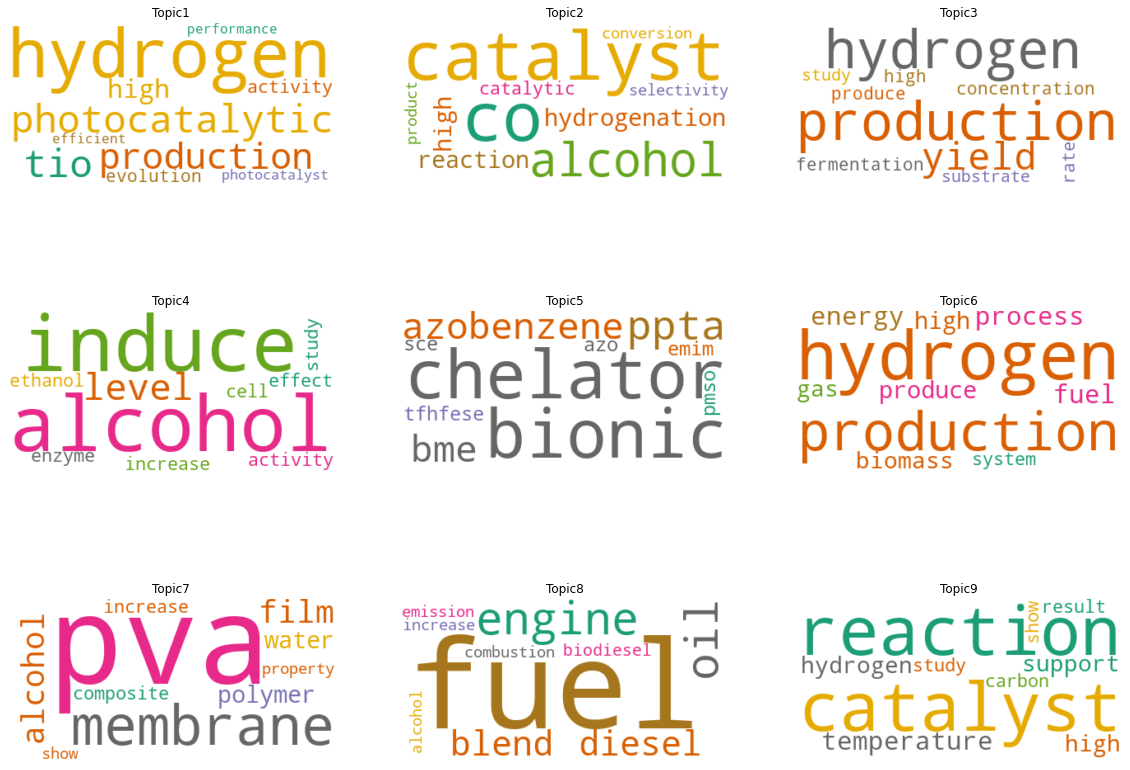

In [21]:
#Visualizing with word clouds
from wordcloud import WordCloud
#wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

#figure size
plt.rcParams['figure.figsize'] = [20, 15]

#subplots for each topic
for i in range(9):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(3, 3, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [22]:
#########################################################################################################

In [23]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.5989,"hydrogen, production, process, energy, fuel, produce, high, gas, biomass, system","[recent_advance, homogeneous, first, row, transition_metal, catalyze, hydrogen, production, important, organic, transformation, methanol, bio, alcohol, current, interest, important, paradigm, development, sustainable, catalysis, early, work, mainly, base, catalyst, present, focus, mainly, earth_abundant, base, metal, co, show, grow, interest, highly, elusive, demand, modern, science, due, low, cost, less, toxic, abundance, review, mainly, aim, describe, topic, hydrogen, formation, organic, transformation, methanol, bio, alcohol, methylation, methylation, methanol, heterocycle, lactam, lactone, hydrogen, formation, diol, bioalcohol, hydrogen, formation, storage, capability, liquid, organic, hydrogen, carrier, additionally, special_attention, pay, utility, reaction, include, brief, reaction, mechanism, scope, reaction]"
1,1,0.0,0.4099,"hydrogen, photocatalytic, tio, production, high, activity, evolution, photocatalyst, performance, efficient","[hydrogen, production, promote, replace, sluggish, oxygen, evolution, reaction, oer, favorable, reaction, primary, oxidation, reaction, benzyl, alcohol, benzaldehyde, benzyl, alcohol, benzaldehyde, realize, selectivity, originate, enhance, adsorption, activation, benzyl, alcohol, photoanode, confirm, test, situ, ftir, technique, electron, generate, controllable, selective, primary, oxidation, reaction, utilize, source, synergistical, hydrogen, production, amount, generate, hydrogen, time, high, oer, efficiency, hydrogen, production, high, propose, strategy, combine, solar, energy, biomass, efficient, production, valuable, raw_material, benzaldehyde, well, green, energy, source, hydrogen]"
2,2,5.0,0.7386,"hydrogen, production, process, energy, fuel, produce, high, gas, biomass, system","[fuel, cell, fc, produce, electricity, continuous, mode, catalytic, reaction, many, possible, application, example, transportation_sector, substitute, combustion_engine, device, regard, free, emission, technology, fuel, obtain, renewable, mode, hydrogen, reform, light, alcohol, obtain, biomass, fermentation, gasification, fact, proton_exchange, membrane, fuel, cell, pemfc, hydrogen, fuel, turn, free, co, later, chemical, specie, poison, platinum, base, catalyst, apply, electrochemical, process, review, aim, clarify, multicomponent, catalyst, hydrogen, production, light, alcohol, reform, overcome_limitation, current, catalyst, specifically, low, thermal, stability, co, formation, suitable, carbon, coke, production, poison, reform, catalyst, byproduct, ch, generation, reduce, hydrogen, amount, produce, pay, applicability, theoretical, method, study, development, improve, multicomponent, catalyst, light, alcohol, reform]"
3,3,0.0,0.7930,"hydrogen, photocatalytic, tio, production, high, activity, evolution, photocatalyst, performance, efficient","[construct, couple, reaction, system, effective, strategy, simultaneously, improve, utilization, photoexcited_electron, hole, cd, photocatalyst, minimize, pt, develop, novel, method, couple, system, hydrogen, production, aromatic, alcohol, oxidation, cd, exhibit, enhance, production, rat, aromatic, aldehyde, respectively, time, high, pure, cd, furthermore, apparent_quantum, efficiency_aqe, hydrogen, production, nm, palpable, decrease, photoactivity, continuous, test, enhance, photocatalytic, activity, mainly, attribute, synergistic, role, pt, cd, large, interfacial, area, form, tight, anchorage, pt, cd, favorable, transfer, photoexcited_electron, metallic, pt, ensure, outstanding, mobility, offer, active_sit, reduce, photoexcited, hole, leave, cd, oxidize, aromatic, alcohol, correspond, aldehyde, thereby, achieve, simultaneous, utilization, photoexcite, reaction, system, anchor, design, also, expand, couple, system]"
4,4,0.0,0.7877,"hydrogen, photocatalytic, tio, production, high, activity, evolution, photocataly

In [24]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(12)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9459,"hydrogen, photocatalytic, tio, production, high, activity, evolution, photocatalyst, performance...","[development, novel, hybrid, photocatalyst, high, efficiency, durability, photocatalytic, degrad..."
1,1.0,0.9505,"catalyst, co, alcohol, hydrogenation, reaction, high, catalytic, selectivity, conversion, product","[soluble, ruthenium, complex, catalyst, investigate, water, water, pressurize, carbon_dioxide, s..."
2,2.0,0.9563,"production, hydrogen, yield, concentration, high, produce, rate, fermentation, substrate, study","[new, fermentative, hydrogen, produce, identify, pantoea, agglomeran, light, microscopic, examin..."
3,3.0,0.9661,"alcohol, induce, level, activity, cell, enzyme, ethanol, increase, effect, study","[excessive, alcohol, user, high, risk, develop, respiratory, infection, compare, individual, chr..."
4,5.0,0.9685,"hydrogen, production, process, energy, fuel, produce, high, gas, biomass, system","[various, form, main, element, necessary, ensure, sustainability, economic, growth, country, lig..."
5,6.0,0.9583,"pva, membrane, film, alcohol, polymer, water, composite, increase, property, show","[quaternary_ammonium, poly, arylene, ether, sulfone, copolymer, random, multi, block, ionomer, s..."
6,7.0,0.9356,"fuel, engine, oil, diesel, blend, biodiesel, combustion, emission, alcohol, increase","[biodiesel, fuel, investigate, extensively, compression_ignition, engine, study, investigate, pe..."
7,8.0,0.9573,"catalyst, reaction, temperature, hydrogen, support, high, study, result, carbon, show","[solubility, nitropyrazole, different, binary, solvent, water, butanol, alcohol, firstly, determ..."


In [50]:
# Get topic weights and dominant topics
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

# Get topic weights
# topic_weights = []
# for i, row_list in enumerate(lda_model[corpus]):
#     topic_weights.append([w for i, w in row_list[0]])
    
# n-1 rows each is a vector with i-1 posisitons, where n the number of documents
# i the topic number and tmp[i] = probability of topic i
topic_weights = []
for row_list in lda_model[corpus]:
    tmp = np.zeros(9)
    for i, w in row_list:
        tmp[i] = w
        topic_weights.append(tmp)
arr = pd.DataFrame(topic_weights).fillna(0).values


# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 9
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
#plt.title('LDA: Topics vs Coherence Score (alpha=0.61, beta=0.61)', fontweight='bold', fontsize=28)
#plt.show()
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 31041 samples in 0.090s...
[t-SNE] Computed neighbors for 31041 samples in 2.286s...
[t-SNE] Computed conditional probabilities for sample 1000 / 31041
[t-SNE] Computed conditional probabilities for sample 2000 / 31041
[t-SNE] Computed conditional probabilities for sample 3000 / 31041
[t-SNE] Computed conditional probabilities for sample 4000 / 31041
[t-SNE] Computed conditional probabilities for sample 5000 / 31041
[t-SNE] Computed conditional probabilities for sample 6000 / 31041
[t-SNE] Computed conditional probabilities for sample 7000 / 31041
[t-SNE] Computed conditional probabilities for sample 8000 / 31041
[t-SNE] Computed conditional probabilities for sample 9000 / 31041
[t-SNE] Computed conditional probabilities for sample 10000 / 31041
[t-SNE] Computed conditional probabilities for sample 11000 / 31041
[t-SNE] Computed conditional probabilities for sample 12000 / 31041
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...